In [140]:
import cv2 
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter
import os 
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random 
import time
import copy
from tqdm import tqdm
import math

In [111]:
IMAGE_PATH = './jcsmr.jpg'

PATCH_SIZE = 64
STRIDE = 32
AUGMENT = True
AUGMENTATION_MULTIPLIER = 3 
VALIDATION_SPLIT = 0.2 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() // 2

# Canny edge parameters 
CANNY_THRESHOLD_1 = 100 # Lower threshold for hysteresis procedure 
CANNY_THRESHOLD_2 = 200 # Upper threshold for hysteresis procedure 

In [112]:
def display_images(images, titles, cmap='gray', figsize=(15, 5), save_path="canny_edge_plot.png"):
    """Helper func to display multiple images"""
    n_images = len(images)
    plt.figure(figsize=figsize)
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        im = plt.imshow(images[i], cmap=cmap if images[i].ndim == 2 else None)
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

In [113]:
print(f"Loading image from: {IMAGE_PATH}")
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"file not found at specified path")

# load in bgr format 
img_bgr = cv2.imread(IMAGE_PATH)

if img_bgr is None:
    raise IOError(f"error: could not read image file")

print(f"image shape: {img_bgr.shape}")

Loading image from: ./jcsmr.jpg
image shape: (3744, 5616, 3)


In [114]:
# convert to grayscale 
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) # canny 

# check for shape and type 
print(f"img shape: {img_gray.shape}, dtype: {img_gray.dtype}")

img shape: (3744, 5616), dtype: uint8


In [115]:
# --------------------------------------------------------------------------------------------
# generate canny edge ground truth
# in: uint8 grayscale img -> out: uint8 binary img (0 or 255)
canny_edges = cv2.Canny(img_gray, threshold1=CANNY_THRESHOLD_1, threshold2=CANNY_THRESHOLD_2)

# convert output (0, 255) to flaot32 map with vals [0, 1] for binary cross entropy loss 
canny = (canny_edges / 255.0).astype(np.float32)

print(f"canny shape: {canny.shape}, dtype: {canny.dtype}, unique values: {np.unique(canny)}")

canny shape: (3744, 5616), dtype: float32, unique values: [0. 1.]


Displaying results


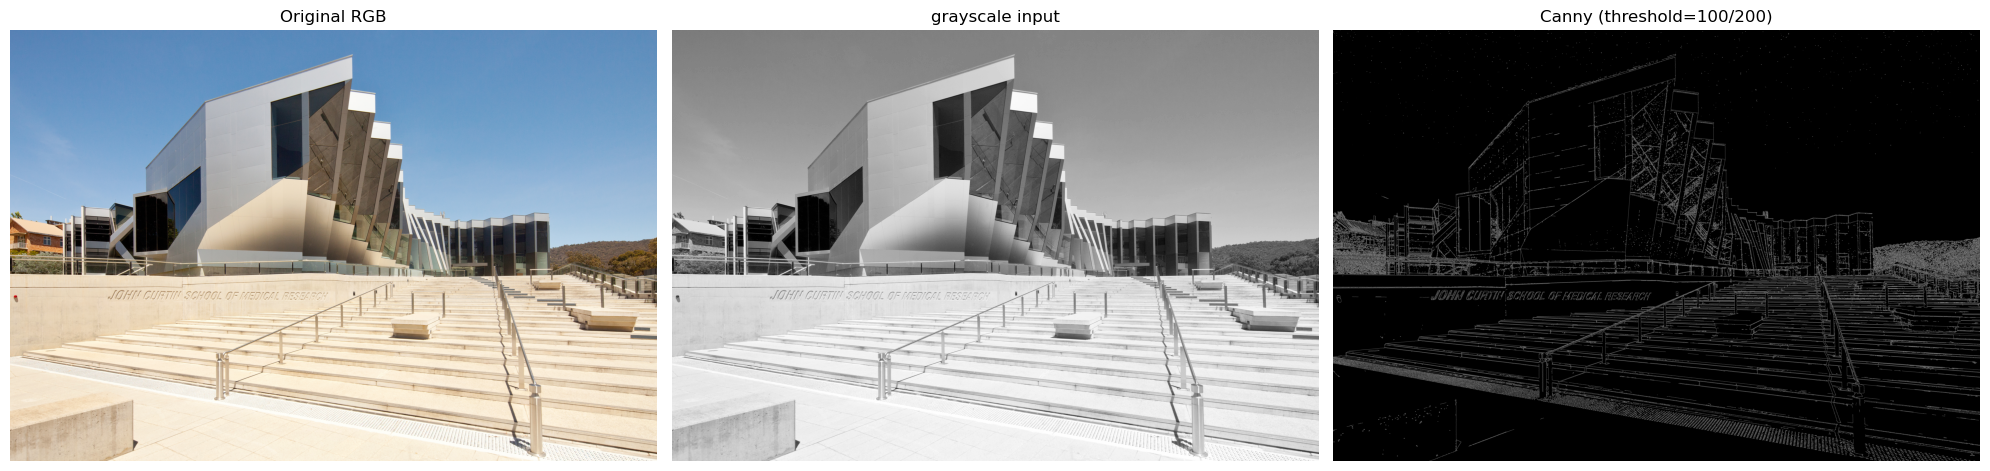

In [116]:
# --- Visualization --- 
print("Displaying results")
display_images(
    [cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB), img_gray, canny], 
    ['Original RGB', "grayscale input", f'Canny (threshold={CANNY_THRESHOLD_1}/{CANNY_THRESHOLD_2})'],
    cmap='gray',
    figsize=(20, 5)
)

In [117]:
def compute_harris_response(Ix: np.ndarray, Iy: np.ndarray, k: float=0.05,
    sigma: float=1.0) ->np.ndarray:
    """Computes the Harris corner response map using the gradient images Ix and Iy.
    You may use the imported gaussian_filter function from scipy.

    Parameters:
        Ix (numpy.ndarray (H, W) [float]): The gradient image in the x-direction.
        Iy (numpy.ndarray (H, W) [float]): The gradient image in the y-direction.
        k (float): Harris detector free parameter, typically between 0.01 and 0.1. Defaults to 0.05.
        sigma (float): Standard deviation for Gaussian filter. Defaults to 1.

    Returns:
        numpy.ndarray (H, W) [float]: The Harris response map.
    """
    # product of derivatives at each pixel
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy 
    Ixy = Ix * Iy 

    # use gaussian filtering to smooth the products
    Ix2_smooth = gaussian_filter(Ix2, sigma=sigma)
    Iy2_smooth = gaussian_filter(Iy2, sigma=sigma)
    Ixy_smooth = gaussian_filter(Ixy, sigma=sigma)

    # Compute the harris response function 
    # R = det(M) - k * (trace(M))**2
    # M is the structure tensor [ [Ix2, Ixy], [Ixy, Iy2] ]

    # Determinant = Ix2 * Iy2 - Ixy**2 
    det_M = Ix2_smooth * Iy2_smooth - (Ixy_smooth * Ixy_smooth)
    # trace = Ix2 + Iy2 
    trace_M = Ix2_smooth + Iy2_smooth

    # Harris response
    R = det_M - k * (trace_M**2)

    return R

In [118]:
def harris_keypoint_nms(response: np.ndarray, threshold: float=0.01,
    window_size: int=5) ->list:
    """Identifies keypoints based on the Harris response using non-maximum suppression.

    Args:
        response (np.ndarray (H, W) [float]): The Harris response map.
        threshold (float, optional): Threshold for keypoint detection. Defaults to 0.01.
        window_size (int, optional): Side-length (odd) of the square window for non-maximum suppression. Defaults to 5.

    Returns:
        list: A list of identified keypoints as (x, y) integer coordinates.
    """
    # ensure window size is odd:
    assert window_size % 2 == 1, "Window size must be odd"

    # height and width of the response map
    height, width = response.shape

    # get half of window for neighbourhood checking
    half_window = window_size // 2

    keypoints = []

    # iterate through all pixels in the response map (excl. border)
    for y in range(half_window, height - half_window):
        for x in range(half_window, width - half_window):
            # skip if response < threshold
            if response[y, x] < threshold:
                continue 
            window = response[y - half_window:y + half_window + 1,
                            x - half_window:x + half_window + 1]
            # check if center pixel is the maximum in the window 
            if response[y, x] == np.max(window):
                # add as keypoint 
                keypoints.append((x, y))
    return keypoints

In [119]:
def compute_DoG(image: np.ndarray, sigma: float=1.6, num_octaves: int=4,
    num_scales: int=5) ->list[list[np.ndarray]]:
    """Computes the Difference of Gaussians (DoG) pyramid for the given image.

    Args:
        image (np.ndarray (H, W) [uint8]): The input grayscale image with shape (H, W).
        sigma (float, optional): The base standard deviation of the Gaussian filter for the first octave. Defaults
            to 1.6, as suggested in SIFT.
        num_octaves (int, optional): Number of octaves in the pyramid. Each octave represents an image downsampled by a
            factor of 2. Defaults to 4.
        num_scales (int, optional): Number of scales per octave (excluding extra layers for DoG computation). Defaults
            to 5.

    Returns:
        list[list[np.ndarray]]: A DoG pyramid, where each inner list represents an octave and contains `num_scales` DoG
            images. Each DoG image has the same shape as the corresponding Gaussian-blurred image in that octave.
            That is, if images in the first octave have shape (H, W) [float32], then the second octave images have
            shape (H//2, W//2) [float32].

    Notes:
        1. The input image should be converted to floating point and **normalized to the range [0,1]** by dividing by 255.0
            to ensure numerical stability.
        2. The standard deviation for each Gaussian blur is computed as:
            sigma_i = sigma * (k^i), where k = 2^(1/num_scales) and i is the scale index.
        3. Since `num_scales + 1` Gaussian images are generated per octave, we get `num_scales` DoG images.
        4. Each **octave** starts from an image and iteratively applies Gaussian smoothing.
           Once all scales are computed, the image is downsampled (reduced to half resolution)
           and used as the base for the next octave.
        5. Use (0, 0) as the kernel size for cv2.GaussianBlur to automatically compute the kernel size.
    """
    img = image.astype(np.float32) / 255.0
    # scale factor
    k = 2.0 ** (1.0 / num_scales)

    dog_pyramid = []
    # curr base img for the octave 
    curr_base_img = img.copy()

    for octave in range(num_octaves):
        # store gaussian blurred imgs for the octave
        gauss_imgs = []
        # store DoG images for this octave 
        dog_imgs = []

        # generate num_scales + 1 gaussian-blurred images for the octave
        for scale in range(num_scales + 1):
            scale_sigma = sigma * (k**scale)
            blurred = cv2.GaussianBlur(curr_base_img, (0,0), scale_sigma)
            gauss_imgs.append(blurred)

            # compute DoG as difference b/w consecutive Gauss imgs 
            if scale > 0:
                DoG = gauss_imgs[scale] - gauss_imgs[scale - 1]
                dog_imgs.append(DoG)
        
        # add the DoG images for this octave to the pyramid 
        dog_pyramid.append(dog_imgs)

        # prepare base img for next octave by downsampling the last gaussian
        # image of the current octave
        if octave < num_octaves - 1:
            curr_base_img = cv2.resize(gauss_imgs[-1],
                                    (gauss_imgs[-1].shape[1] // 2,
                                    gauss_imgs[-1].shape[0] // 2),
                                    interpolation=cv2.INTER_AREA)
    return dog_pyramid

In [120]:
def match_features(descriptors1: np.ndarray, descriptors2: np.ndarray,
    ratio_thresh: float=0.75) ->list:
    """Matches features between two descriptor sets using the L2 distance (np.linalg.norm).
    A feature in the first set (descriptors1) is matched to the closest feature in the second set (descriptors2),
    in the L2 sense, so long as it passes Lowe's Ratio Test.

    Args:
        descriptors1 (np.ndarray (N, 128) [float32]): Descriptors from image 1.
        descriptors2 (np.ndarray (N, 128) [float32]): Descriptors from image 2.
        ratio_thresh (float): Lowe’s Ratio Test threshold.

    Returns:
        matches (list[tuple]): Matched keypoint indices [(idx1_0, idx2_0), ..., (idx1_k, idx2_k)].
    """
    matches = []
    # for each descriptor in the first set, init variables to track the 
    # two closest matches 
    for i, desc1 in enumerate(descriptors1):
        best_dist = float('inf')
        second_best_dist = float('inf')
        best_idx = -1

        # compare with all desc in the second set
        for j, desc2 in enumerate(descriptors2):
            # compute L2 dist b/w descriptors 
            dist = np.linalg.norm(desc1 - desc2)

            if dist < best_dist:
                second_best_dist = best_dist
                best_dist = dist
                best_idx = j 
            elif dist < second_best_dist:
                second_best_dist = dist 
        
        # lowe's ratio test 
        if best_dist < ratio_thresh * second_best_dist:
            matches.append((i, best_idx))
    
    return matches

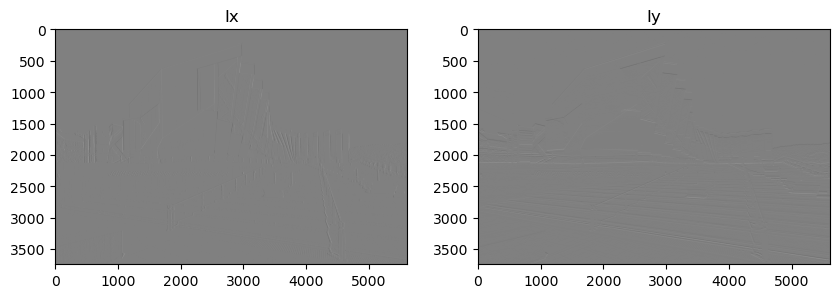

In [121]:
Ix = cv2.Sobel(img_gray, cv2.CV_32F, 1, 0, ksize=3)
Iy = cv2.Sobel(img_gray, cv2.CV_32F, 0, 1, ksize=3)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Ix, cmap="gray")
plt.title("Ix")
plt.subplot(1, 2, 2)
plt.imshow(Iy, cmap="gray")
plt.title("Iy")
plt.show()

Text(0.5, 1.0, 'Harris Response Map')

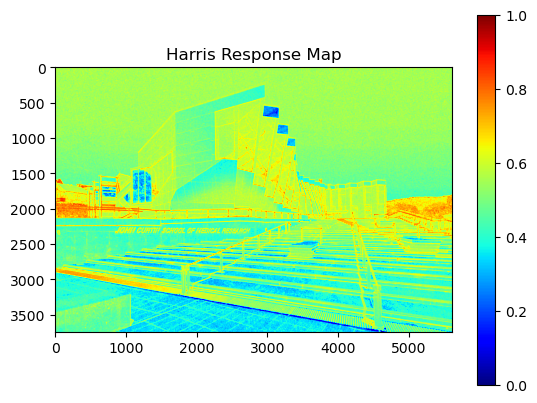

In [122]:
k = 0.04
sigma = 1.0
harris_response = compute_harris_response(Ix, Iy, k, sigma)
# Normalize the response for better visualization
harris_response_vis = np.log(1 + np.abs(harris_response))
harris_response_vis = (harris_response_vis - harris_response_vis.min()) / (
    harris_response_vis.max() - harris_response_vis.min()
)
plt.imshow(harris_response_vis, cmap="jet")
plt.colorbar()
plt.title("Harris Response Map")

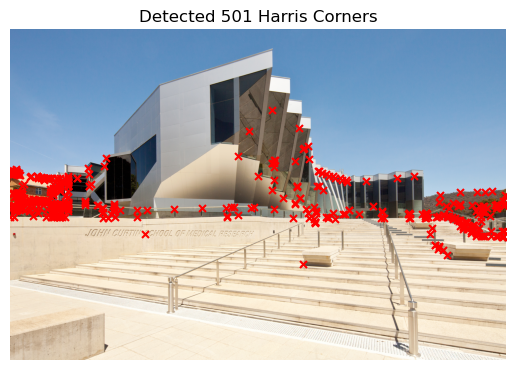

In [123]:
threshold = 0.1 * np.max(harris_response)
keypoints = harris_keypoint_nms(harris_response, threshold, 5)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.scatter(*zip(*keypoints), c="r", s=25, marker="x")
plt.title(f"Detected {len(keypoints)} Harris Corners")
plt.axis("off")
plt.savefig("harris_corners.png")

In [124]:
assert img_gray.shape == harris_response_vis.shape == canny_float.shape, "Input img and ground truth maps must have same dims."

In [125]:
H, W = img_gray.shape
print(f"Image dimensions: H={H}, W={W}")
print(f"Patch Size: {PATCH_SIZE}, Stride: {STRIDE}")

Image dimensions: H=3744, W=5616
Patch Size: 64, Stride: 32


In [126]:
# extract patches
patch_triplets = [] # List to hold (input_patch, harris_patch, canny_patch)

for y in range(0, H - PATCH_SIZE + 1, STRIDE):
    for x in range(0, W - PATCH_SIZE + 1, STRIDE):
        input_patch = img_gray[y : y + PATCH_SIZE, x : x + PATCH_SIZE]
        harris_patch = harris_response_vis[y : y + PATCH_SIZE, x : x + PATCH_SIZE]
        canny_patch = canny[y : y + PATCH_SIZE, x : x + PATCH_SIZE]

        # discard patches with low variance (like most of the sky)
        if np.std(input_patch) < 5: # ex. threshold of 5
            continue

        patch_triplets.append((input_patch, harris_patch, canny_patch))

print(f"Extracted {len(patch_triplets)} original patches.")

Extracted 18016 original patches.


In [127]:
# apply augmentation to patches 
if AUGMENT:
    print(f"Augmenting patches with Multiplier: {AUGMENTATION_MULTIPLIER}")
    augmented_patches = []
    for _ in range(AUGMENTATION_MULTIPLIER):
        for input, harris, canny in patch_triplets:
            # rand augmentation
            aug_type = random.choice(['rotate90', 'rotate180', 'rotate270', 'flip_h', 'flip_v', 'none'])

            input_aug, harris_aug, canny_aug = input.copy(), harris.copy(), canny.copy()

            if aug_type == 'rotate90':
                input_aug = cv2.rotate(input_aug, cv2.ROTATE_90_CLOCKWISE)
                harris_aug = cv2.rotate(harris_aug, cv2.ROTATE_90_CLOCKWISE)
                canny_aug = cv2.rotate(canny_aug, cv2.ROTATE_90_CLOCKWISE)
            elif aug_type == 'rotate180':
                input_aug = cv2.rotate(input_aug, cv2.ROTATE_180)
                harris_aug = cv2.rotate(harris_aug, cv2.ROTATE_180)
                canny_aug = cv2.rotate(canny_aug, cv2.ROTATE_180)
            elif aug_type == 'rotate270':
                input_aug = cv2.rotate(input_aug, cv2.ROTATE_90_COUNTERCLOCKWISE)
                harris_aug = cv2.rotate(harris_aug, cv2.ROTATE_90_COUNTERCLOCKWISE)
                canny_aug = cv2.rotate(canny_aug, cv2.ROTATE_90_COUNTERCLOCKWISE)
            elif aug_type == 'flip_h':
                input_aug = cv2.flip(input_aug, 1) # Horizontal flip
                harris_aug = cv2.flip(harris_aug, 1)
                canny_aug = cv2.flip(canny_aug, 1)
            elif aug_type == 'flip_v':
                input_aug = cv2.flip(input_aug, 0) # Vertical flip
                harris_aug = cv2.flip(harris_aug, 0)
                canny_aug = cv2.flip(canny_aug, 0)

            augmented_patches.append((input_aug, harris_aug, canny_aug))

    total_patches = patch_triplets + augmented_patches
    print(f"Total patches after augmentation: {len(total_patches)}")

else:
    total_patches = patch_triplets
    print("Skipping augmentation.")

Augmenting patches with Multiplier: 3
Total patches after augmentation: 72064


In [128]:
# split data into train and val sets 
train_patches, val_patches = train_test_split(
    total_patches,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    shuffle=True
)

print(f"Training patches: {len(train_patches)}")
print(f"Validation patches: {len(val_patches)}")

Training patches: 57651
Validation patches: 14413


In [131]:
# Create torch dataset class

class PatchDataset(Dataset):
    def __init__(self, patch_list):
        self.patch_list = patch_list

    def __len__(self):
        return len(self.patch_list)

    def __getitem__(self, idx):
        input_patch_np, harris_patch_np, canny_patch_np = self.patch_list[idx]

        # Convert to float32 and normalize input patch to [0, 1]
        input_patch_tensor = torch.from_numpy(input_patch_np.astype(np.float32) / 255.0)
        harris_patch_tensor = torch.from_numpy(harris_patch_np.astype(np.float32))
        canny_patch_tensor = torch.from_numpy(canny_patch_np.astype(np.float32))

        # Add channel dimension (C, H, W)
        # *Grayscale images have 1 channel
        input_patch_tensor = input_patch_tensor.unsqueeze(0)
        harris_patch_tensor = harris_patch_tensor.unsqueeze(0)
        canny_patch_tensor = canny_patch_tensor.unsqueeze(0)

        return input_patch_tensor, harris_patch_tensor, canny_patch_tensor

DataLoaders created successfully.
Sample batch - Input shape: torch.Size([32, 1, 64, 64])
Sample batch - Harris GT shape: torch.Size([32, 1, 64, 64])
Sample batch - Canny GT shape: torch.Size([32, 1, 64, 64])


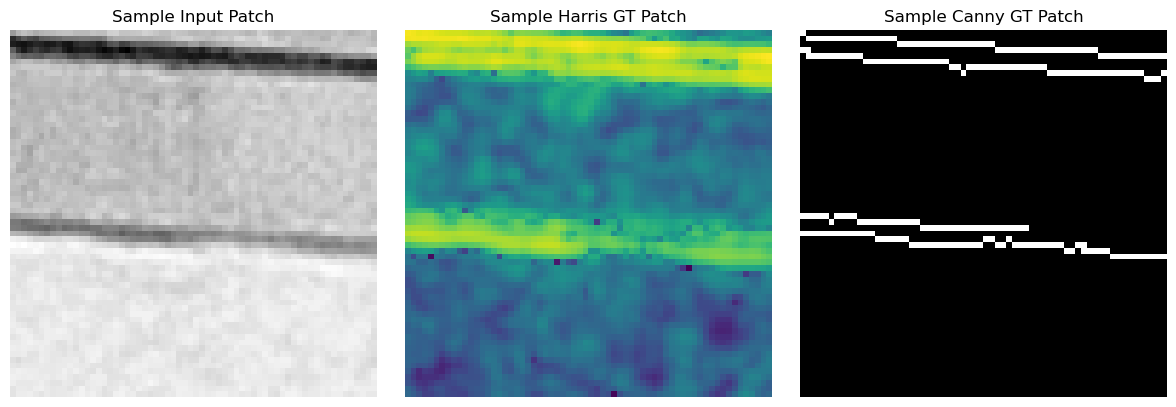


Data Preparation Complete.
Variables available: train_loader, val_loader


In [132]:
# create datasets and dataloaders

train_dataset = PatchDataset(train_patches)
val_dataset = PatchDataset(val_patches)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("DataLoaders created successfully.")

# visualize a sample batch
try:
    sample_inputs, sample_harris, sample_canny = next(iter(train_loader))
    print(f"Sample batch - Input shape: {sample_inputs.shape}")     # Should be [BATCH_SIZE, 1, PATCH_SIZE, PATCH_SIZE]
    print(f"Sample batch - Harris GT shape: {sample_harris.shape}") # Should be [BATCH_SIZE, 1, PATCH_SIZE, PATCH_SIZE]
    print(f"Sample batch - Canny GT shape: {sample_canny.shape}")   # Should be [BATCH_SIZE, 1, PATCH_SIZE, PATCH_SIZE]

    # Display the first image from the batch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(sample_inputs[0, 0].numpy(), cmap='gray') 
    plt.title('Sample Input Patch')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sample_harris[0, 0].numpy(), cmap='viridis')
    plt.title('Sample Harris GT Patch')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sample_canny[0, 0].numpy(), cmap='gray')
    plt.title('Sample Canny GT Patch')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig("batch.png")
    plt.show()

except Exception as e:
    print(f"Could not visualize sample batch: {e}")
    print("DataLoader failed.")

print("\nData Preparation Complete.")

In [ ]:
# Plan:
# 1. setup a U-net architecture which is good for image-to-image tasks
# 2. Instantiate two separate models for Harris and Canny
# 3. Implement loss functions and optimizers
# 4. Create a training loop as well as a validation process

In [134]:
# U-Net
class DoubleConv(nn.Module):
    """(Conv -> [BN] -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)



class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then DoubleConv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use normal conv to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is C H W
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor) 
        self.up1 = Up(512, 256 // factor, bilinear) 
        self.up2 = Up(256, 128 // factor, bilinear) 
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        # sigmoid activation for BCELoss or regression between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        # Apply sigmoid for final output
        output = self.sigmoid(logits)
        return output

In [135]:
# Training configuration 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

LEARNING_RATE_HARRIS = 1e-4 # tune later
LEARNING_RATE_CANNY = 1e-4
NUM_EPOCHS = 100

# init models 
model_harris = UNet(n_channels=1, n_classes=1).to(device)
model_canny = UNet(n_channels=1, n_classes=1).to(device)

# loss functions
# MSE loss for harris heatmap regression (b/w 0 & 1)
criterion_harris = nn.MSELoss()
# BCE loss for canny edge prediction (0 or 1, model outputs sigmoid probability)
criterion_canny = nn.BCELoss()

# Optimizers
optimizer_harris = optim.Adam(model_harris.parameters(), lr=LEARNING_RATE_HARRIS)
optimizer_canny = optim.Adam(model_canny.parameters(), lr=LEARNING_RATE_CANNY)

Using device: cuda


In [138]:
# Training loop
def train_model(model_h, criterion_h, optimizer_h,
                model_c, criterion_c, optimizer_c,
                dataloaders, device, num_epochs=25):
    """
    Trains both Harris and Canny models.
    Args:
        model_h: Harris prediction model
        criterion_h: Harris loss function
        optimizer_h: Harris optimizer
        model_c: Canny prediction model
        criterion_c: Canny loss function
        optimizer_c: Canny optimizer
        dataloaders (dict): Dictionary containing 'train' and 'val' DataLoaders
        device: torch.device ('cuda' or 'cpu')
        num_epochs (int): Number of epochs to train for

    Returns:
        tuple: (best_harris_model_state, best_canny_model_state) containing state_dicts
               of the models with the lowest validation loss for each task.
    """
    start = time.time()

    best_harris_model_wts = copy.deepcopy(model_h.state_dict())
    best_canny_model_wts = copy.deepcopy(model_c.state_dict())
    best_harris_loss = float('inf')
    best_canny_loss = float('inf')

    # store losses for plotting 
    history = {'train_loss_h': [], 'val_loss_h': [], 'train_loss_c': [], 'val_loss_c': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                # set model to train mode
                model_h.train() 
                model_c.train()
            else:
                # set models to eval mode
                model_h.eval() 
                model_c.eval()

            running_loss_h = 0.0
            running_loss_c = 0.0

            # iterate over data
            loader = dataloaders[phase]
            pbar = tqdm(loader, desc=f"{phase.capitalize()} Epoch {epoch+1}")

            for inputs, harris, canny in pbar:
                inputs = inputs.to(device)
                harris = harris.to(device)
                canny = canny.to(device)

                # harris task 
                optimizer_h.zero_grad()
                # forward pass 
                with torch.set_grad_enabled(phase == 'train'):
                    harris_pred = model_h(inputs)
                    loss_h = criterion_h(harris_pred, harris)

                    # backward + optimize
                    if phase == 'train':
                        loss_h.backward()
                        optimizer_h.step()

                # canny task
                optimizer_c.zero_grad()
                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    canny_pred = model_c(inputs)
                    loss_c = criterion_c(canny_pred, canny)

                    # backward + optimize
                    if phase == 'train':
                        loss_c.backward()
                        optimizer_c.step()

                # stats
                batch_loss_h = loss_h.item() * inputs.size(0)
                batch_loss_c = loss_c.item() * inputs.size(0)
                running_loss_h += batch_loss_h
                running_loss_c += batch_loss_c

                # update progress bar 
                pbar.set_postfix({'Loss H': batch_loss_h / inputs.size(0), 'Loss C': batch_loss_c / inputs.size(0)})

            epoch_loss_h = running_loss_h / len(loader.dataset)
            epoch_loss_c = running_loss_c / len(loader.dataset)

            print(f'{phase.capitalize()} Harris Loss: {epoch_loss_h:.4f} Canny Loss: {epoch_loss_c:.4f}')

            # store history
            if phase == 'train':
                history['train_loss_h'].append(epoch_loss_h)
                history['train_loss_c'].append(epoch_loss_c)
            else: 
                history['val_loss_h'].append(epoch_loss_h)
                history['val_loss_c'].append(epoch_loss_c)

                if epoch_loss_h < best_harris_loss:
                    best_harris_loss = epoch_loss_h
                    best_harris_model_wts = copy.deepcopy(model_h.state_dict())
                    print(f"  -> New best Harris validation loss: {best_harris_loss:.4f}")
                if epoch_loss_c < best_canny_loss:
                    best_canny_loss = epoch_loss_c
                    best_canny_model_wts = copy.deepcopy(model_c.state_dict())
                    print(f"  -> New best Canny validation loss: {best_canny_loss:.4f}")
        print()

    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Harris Loss: {best_harris_loss:4f}')
    print(f'Best val Canny Loss: {best_canny_loss:4f}')

    # Load best model weights back into models
    model_h.load_state_dict(best_harris_model_wts)
    model_c.load_state_dict(best_canny_model_wts)
    return model_h, model_c, history 

Epoch 1/100
----------


Train Epoch 1: 100%|██████████| 1802/1802 [00:49<00:00, 36.55it/s, Loss H=0.000987, Loss C=0.0649]


Train Harris Loss: 0.0014 Canny Loss: 0.1369


Val Epoch 1: 100%|██████████| 451/451 [00:04<00:00, 90.51it/s, Loss H=0.00131, Loss C=0.0517]  


Val Harris Loss: 0.0011 Canny Loss: 0.0560
  -> New best Harris validation loss: 0.0011
  -> New best Canny validation loss: 0.0560

Epoch 2/100
----------


Train Epoch 2: 100%|██████████| 1802/1802 [00:49<00:00, 36.61it/s, Loss H=0.000587, Loss C=0.0289]


Train Harris Loss: 0.0008 Canny Loss: 0.0435


Val Epoch 2: 100%|██████████| 451/451 [00:05<00:00, 87.69it/s, Loss H=0.000713, Loss C=0.0326] 


Val Harris Loss: 0.0006 Canny Loss: 0.0366
  -> New best Harris validation loss: 0.0006
  -> New best Canny validation loss: 0.0366

Epoch 3/100
----------


Train Epoch 3: 100%|██████████| 1802/1802 [00:47<00:00, 37.62it/s, Loss H=0.000556, Loss C=0.0298]


Train Harris Loss: 0.0006 Canny Loss: 0.0332


Val Epoch 3: 100%|██████████| 451/451 [00:04<00:00, 96.61it/s, Loss H=0.000591, Loss C=0.0261] 


Val Harris Loss: 0.0006 Canny Loss: 0.0308
  -> New best Harris validation loss: 0.0006
  -> New best Canny validation loss: 0.0308

Epoch 4/100
----------


Train Epoch 4: 100%|██████████| 1802/1802 [00:45<00:00, 39.21it/s, Loss H=0.000473, Loss C=0.0203]


Train Harris Loss: 0.0005 Canny Loss: 0.0291


Val Epoch 4: 100%|██████████| 451/451 [00:04<00:00, 96.69it/s, Loss H=0.0005, Loss C=0.0237]   


Val Harris Loss: 0.0005 Canny Loss: 0.0282
  -> New best Harris validation loss: 0.0005
  -> New best Canny validation loss: 0.0282

Epoch 5/100
----------


Train Epoch 5: 100%|██████████| 1802/1802 [00:45<00:00, 39.31it/s, Loss H=0.000646, Loss C=0.0379]


Train Harris Loss: 0.0004 Canny Loss: 0.0266


Val Epoch 5: 100%|██████████| 451/451 [00:04<00:00, 96.64it/s, Loss H=0.000407, Loss C=0.0219] 


Val Harris Loss: 0.0004 Canny Loss: 0.0261
  -> New best Harris validation loss: 0.0004
  -> New best Canny validation loss: 0.0261

Epoch 6/100
----------


Train Epoch 6: 100%|██████████| 1802/1802 [00:45<00:00, 39.21it/s, Loss H=0.000341, Loss C=0.0214] 


Train Harris Loss: 0.0004 Canny Loss: 0.0247


Val Epoch 6: 100%|██████████| 451/451 [00:04<00:00, 96.61it/s, Loss H=0.000384, Loss C=0.0203] 


Val Harris Loss: 0.0004 Canny Loss: 0.0243
  -> New best Harris validation loss: 0.0004
  -> New best Canny validation loss: 0.0243

Epoch 7/100
----------


Train Epoch 7: 100%|██████████| 1802/1802 [00:45<00:00, 39.31it/s, Loss H=0.000348, Loss C=0.0306] 


Train Harris Loss: 0.0003 Canny Loss: 0.0232


Val Epoch 7: 100%|██████████| 451/451 [00:04<00:00, 96.57it/s, Loss H=0.000339, Loss C=0.0196] 


Val Harris Loss: 0.0003 Canny Loss: 0.0234
  -> New best Harris validation loss: 0.0003
  -> New best Canny validation loss: 0.0234

Epoch 8/100
----------


Train Epoch 8: 100%|██████████| 1802/1802 [00:46<00:00, 39.15it/s, Loss H=0.000255, Loss C=0.011]  


Train Harris Loss: 0.0003 Canny Loss: 0.0217


Val Epoch 8: 100%|██████████| 451/451 [00:04<00:00, 96.48it/s, Loss H=0.000305, Loss C=0.0181] 


Val Harris Loss: 0.0003 Canny Loss: 0.0223
  -> New best Harris validation loss: 0.0003
  -> New best Canny validation loss: 0.0223

Epoch 9/100
----------


Train Epoch 9: 100%|██████████| 1802/1802 [00:45<00:00, 39.23it/s, Loss H=0.000275, Loss C=0.0131] 


Train Harris Loss: 0.0003 Canny Loss: 0.0203


Val Epoch 9: 100%|██████████| 451/451 [00:04<00:00, 96.40it/s, Loss H=0.000278, Loss C=0.0163]  


Val Harris Loss: 0.0003 Canny Loss: 0.0208
  -> New best Harris validation loss: 0.0003
  -> New best Canny validation loss: 0.0208

Epoch 10/100
----------


Train Epoch 10: 100%|██████████| 1802/1802 [00:45<00:00, 39.28it/s, Loss H=0.000332, Loss C=0.0193] 


Train Harris Loss: 0.0003 Canny Loss: 0.0190


Val Epoch 10: 100%|██████████| 451/451 [00:04<00:00, 96.29it/s, Loss H=0.00029, Loss C=0.017]    


Val Harris Loss: 0.0002 Canny Loss: 0.0200
  -> New best Harris validation loss: 0.0002
  -> New best Canny validation loss: 0.0200

Epoch 11/100
----------


Train Epoch 11: 100%|██████████| 1802/1802 [00:45<00:00, 39.20it/s, Loss H=0.000399, Loss C=0.0211] 


Train Harris Loss: 0.0003 Canny Loss: 0.0177


Val Epoch 11: 100%|██████████| 451/451 [00:04<00:00, 96.39it/s, Loss H=0.000244, Loss C=0.0156]  


Val Harris Loss: 0.0002 Canny Loss: 0.0189
  -> New best Harris validation loss: 0.0002
  -> New best Canny validation loss: 0.0189

Epoch 12/100
----------


Train Epoch 12: 100%|██████████| 1802/1802 [00:45<00:00, 39.22it/s, Loss H=0.000201, Loss C=0.0128] 


Train Harris Loss: 0.0002 Canny Loss: 0.0166


Val Epoch 12: 100%|██████████| 451/451 [00:04<00:00, 96.50it/s, Loss H=0.000243, Loss C=0.0146]  


Val Harris Loss: 0.0002 Canny Loss: 0.0183
  -> New best Harris validation loss: 0.0002
  -> New best Canny validation loss: 0.0183

Epoch 13/100
----------


Train Epoch 13: 100%|██████████| 1802/1802 [00:45<00:00, 39.21it/s, Loss H=0.000248, Loss C=0.0231] 


Train Harris Loss: 0.0002 Canny Loss: 0.0156


Val Epoch 13: 100%|██████████| 451/451 [00:04<00:00, 96.56it/s, Loss H=0.000246, Loss C=0.0144]  


Val Harris Loss: 0.0002 Canny Loss: 0.0176
  -> New best Canny validation loss: 0.0176

Epoch 14/100
----------


Train Epoch 14: 100%|██████████| 1802/1802 [00:45<00:00, 39.28it/s, Loss H=0.000265, Loss C=0.0128] 


Train Harris Loss: 0.0002 Canny Loss: 0.0146


Val Epoch 14: 100%|██████████| 451/451 [00:04<00:00, 96.68it/s, Loss H=0.000265, Loss C=0.0132]  


Val Harris Loss: 0.0002 Canny Loss: 0.0175
  -> New best Harris validation loss: 0.0002
  -> New best Canny validation loss: 0.0175

Epoch 15/100
----------


Train Epoch 15: 100%|██████████| 1802/1802 [00:45<00:00, 39.20it/s, Loss H=0.000162, Loss C=0.00769]


Train Harris Loss: 0.0002 Canny Loss: 0.0139


Val Epoch 15: 100%|██████████| 451/451 [00:04<00:00, 96.51it/s, Loss H=0.000231, Loss C=0.0125]  


Val Harris Loss: 0.0002 Canny Loss: 0.0177
  -> New best Harris validation loss: 0.0002

Epoch 16/100
----------


Train Epoch 16: 100%|██████████| 1802/1802 [00:45<00:00, 39.19it/s, Loss H=0.000133, Loss C=0.00955]


Train Harris Loss: 0.0002 Canny Loss: 0.0132


Val Epoch 16: 100%|██████████| 451/451 [00:04<00:00, 96.49it/s, Loss H=0.000232, Loss C=0.0117]  


Val Harris Loss: 0.0002 Canny Loss: 0.0163
  -> New best Canny validation loss: 0.0163

Epoch 17/100
----------


Train Epoch 17: 100%|██████████| 1802/1802 [00:45<00:00, 39.21it/s, Loss H=0.000261, Loss C=0.016]  


Train Harris Loss: 0.0002 Canny Loss: 0.0125


Val Epoch 17: 100%|██████████| 451/451 [00:04<00:00, 96.37it/s, Loss H=0.000256, Loss C=0.0119]  


Val Harris Loss: 0.0002 Canny Loss: 0.0161
  -> New best Canny validation loss: 0.0161

Epoch 18/100
----------


Train Epoch 18: 100%|██████████| 1802/1802 [00:45<00:00, 39.21it/s, Loss H=0.00019, Loss C=0.0114]  


Train Harris Loss: 0.0002 Canny Loss: 0.0118


Val Epoch 18: 100%|██████████| 451/451 [00:04<00:00, 96.37it/s, Loss H=0.000198, Loss C=0.0116]  


Val Harris Loss: 0.0002 Canny Loss: 0.0155
  -> New best Harris validation loss: 0.0002
  -> New best Canny validation loss: 0.0155

Epoch 19/100
----------


Train Epoch 19: 100%|██████████| 1802/1802 [00:45<00:00, 39.22it/s, Loss H=0.000157, Loss C=0.00749]


Train Harris Loss: 0.0002 Canny Loss: 0.0113


Val Epoch 19: 100%|██████████| 451/451 [00:04<00:00, 96.53it/s, Loss H=0.0002, Loss C=0.0105]    


Val Harris Loss: 0.0002 Canny Loss: 0.0154
  -> New best Canny validation loss: 0.0154

Epoch 20/100
----------


Train Epoch 20: 100%|██████████| 1802/1802 [00:46<00:00, 39.14it/s, Loss H=0.000215, Loss C=0.00844]


Train Harris Loss: 0.0002 Canny Loss: 0.0108


Val Epoch 20: 100%|██████████| 451/451 [00:04<00:00, 96.41it/s, Loss H=0.000196, Loss C=0.0108]  


Val Harris Loss: 0.0002 Canny Loss: 0.0150
  -> New best Harris validation loss: 0.0002
  -> New best Canny validation loss: 0.0150

Epoch 21/100
----------


Train Epoch 21: 100%|██████████| 1802/1802 [00:45<00:00, 39.21it/s, Loss H=0.000246, Loss C=0.0167] 


Train Harris Loss: 0.0002 Canny Loss: 0.0104


Val Epoch 21: 100%|██████████| 451/451 [00:04<00:00, 96.47it/s, Loss H=0.000265, Loss C=0.0106]  


Val Harris Loss: 0.0002 Canny Loss: 0.0148
  -> New best Canny validation loss: 0.0148

Epoch 22/100
----------


Train Epoch 22: 100%|██████████| 1802/1802 [00:45<00:00, 39.18it/s, Loss H=0.000163, Loss C=0.00941]


Train Harris Loss: 0.0002 Canny Loss: 0.0099


Val Epoch 22: 100%|██████████| 451/451 [00:04<00:00, 96.36it/s, Loss H=0.000187, Loss C=0.0104]  


Val Harris Loss: 0.0002 Canny Loss: 0.0151

Epoch 23/100
----------


Train Epoch 23: 100%|██████████| 1802/1802 [00:45<00:00, 39.19it/s, Loss H=0.000192, Loss C=0.00674]


Train Harris Loss: 0.0002 Canny Loss: 0.0096


Val Epoch 23: 100%|██████████| 451/451 [00:04<00:00, 96.46it/s, Loss H=0.000237, Loss C=0.0101]  


Val Harris Loss: 0.0002 Canny Loss: 0.0147
  -> New best Canny validation loss: 0.0147

Epoch 24/100
----------


Train Epoch 24: 100%|██████████| 1802/1802 [00:45<00:00, 39.21it/s, Loss H=0.000176, Loss C=0.00858]


Train Harris Loss: 0.0002 Canny Loss: 0.0092


Val Epoch 24: 100%|██████████| 451/451 [00:04<00:00, 96.34it/s, Loss H=0.000189, Loss C=0.00993] 


Val Harris Loss: 0.0002 Canny Loss: 0.0142
  -> New best Harris validation loss: 0.0002
  -> New best Canny validation loss: 0.0142

Epoch 25/100
----------


Train Epoch 25: 100%|██████████| 1802/1802 [00:45<00:00, 39.21it/s, Loss H=0.000148, Loss C=0.00449]


Train Harris Loss: 0.0002 Canny Loss: 0.0088


Val Epoch 25: 100%|██████████| 451/451 [00:04<00:00, 96.20it/s, Loss H=0.000195, Loss C=0.00989] 


Val Harris Loss: 0.0002 Canny Loss: 0.0151
  -> New best Harris validation loss: 0.0002

Epoch 26/100
----------


Train Epoch 26: 100%|██████████| 1802/1802 [00:45<00:00, 39.21it/s, Loss H=0.000158, Loss C=0.00878]


Train Harris Loss: 0.0002 Canny Loss: 0.0085


Val Epoch 26: 100%|██████████| 451/451 [00:04<00:00, 96.30it/s, Loss H=0.000219, Loss C=0.0104]  


Val Harris Loss: 0.0003 Canny Loss: 0.0144

Epoch 27/100
----------


Train Epoch 27: 100%|██████████| 1802/1802 [00:45<00:00, 39.30it/s, Loss H=0.000161, Loss C=0.00581]


Train Harris Loss: 0.0002 Canny Loss: 0.0082


Val Epoch 27: 100%|██████████| 451/451 [00:04<00:00, 96.72it/s, Loss H=0.000186, Loss C=0.00995] 


Val Harris Loss: 0.0002 Canny Loss: 0.0142
  -> New best Canny validation loss: 0.0142

Epoch 28/100
----------


Train Epoch 28: 100%|██████████| 1802/1802 [00:46<00:00, 39.11it/s, Loss H=0.000169, Loss C=0.0119] 


Train Harris Loss: 0.0002 Canny Loss: 0.0079


Val Epoch 28: 100%|██████████| 451/451 [00:04<00:00, 96.51it/s, Loss H=0.000179, Loss C=0.00974] 


Val Harris Loss: 0.0002 Canny Loss: 0.0148

Epoch 29/100
----------


Train Epoch 29: 100%|██████████| 1802/1802 [00:46<00:00, 39.11it/s, Loss H=0.000188, Loss C=0.00687]


Train Harris Loss: 0.0002 Canny Loss: 0.0076


Val Epoch 29: 100%|██████████| 451/451 [00:04<00:00, 96.24it/s, Loss H=0.000346, Loss C=0.00909] 


Val Harris Loss: 0.0003 Canny Loss: 0.0148

Epoch 30/100
----------


Train Epoch 30: 100%|██████████| 1802/1802 [00:46<00:00, 39.09it/s, Loss H=0.00016, Loss C=0.0112]  


Train Harris Loss: 0.0002 Canny Loss: 0.0074


Val Epoch 30: 100%|██████████| 451/451 [00:04<00:00, 96.21it/s, Loss H=0.000177, Loss C=0.00896] 


Val Harris Loss: 0.0002 Canny Loss: 0.0146
  -> New best Harris validation loss: 0.0002

Epoch 31/100
----------


Train Epoch 31: 100%|██████████| 1802/1802 [00:45<00:00, 39.19it/s, Loss H=0.000156, Loss C=0.00989]


Train Harris Loss: 0.0002 Canny Loss: 0.0071


Val Epoch 31: 100%|██████████| 451/451 [00:04<00:00, 96.50it/s, Loss H=0.000169, Loss C=0.00993] 


Val Harris Loss: 0.0002 Canny Loss: 0.0142
  -> New best Harris validation loss: 0.0002

Epoch 32/100
----------


Train Epoch 32: 100%|██████████| 1802/1802 [00:46<00:00, 39.12it/s, Loss H=0.000141, Loss C=0.00604]


Train Harris Loss: 0.0001 Canny Loss: 0.0069


Val Epoch 32: 100%|██████████| 451/451 [00:04<00:00, 96.28it/s, Loss H=0.000157, Loss C=0.00982] 


Val Harris Loss: 0.0001 Canny Loss: 0.0145
  -> New best Harris validation loss: 0.0001

Epoch 33/100
----------


Train Epoch 33: 100%|██████████| 1802/1802 [00:45<00:00, 39.26it/s, Loss H=0.000162, Loss C=0.00507]


Train Harris Loss: 0.0001 Canny Loss: 0.0067


Val Epoch 33: 100%|██████████| 451/451 [00:04<00:00, 96.38it/s, Loss H=0.000172, Loss C=0.00958] 


Val Harris Loss: 0.0002 Canny Loss: 0.0145

Epoch 34/100
----------


Train Epoch 34: 100%|██████████| 1802/1802 [00:45<00:00, 39.18it/s, Loss H=0.000182, Loss C=0.013]  


Train Harris Loss: 0.0001 Canny Loss: 0.0064


Val Epoch 34: 100%|██████████| 451/451 [00:04<00:00, 96.29it/s, Loss H=0.000173, Loss C=0.00908] 


Val Harris Loss: 0.0002 Canny Loss: 0.0149

Epoch 35/100
----------


Train Epoch 35: 100%|██████████| 1802/1802 [00:46<00:00, 39.17it/s, Loss H=0.000119, Loss C=0.00258]


Train Harris Loss: 0.0001 Canny Loss: 0.0063


Val Epoch 35: 100%|██████████| 451/451 [00:04<00:00, 96.37it/s, Loss H=0.000151, Loss C=0.00954] 


Val Harris Loss: 0.0002 Canny Loss: 0.0145

Epoch 36/100
----------


Train Epoch 36: 100%|██████████| 1802/1802 [00:46<00:00, 39.17it/s, Loss H=0.000121, Loss C=0.00351]


Train Harris Loss: 0.0001 Canny Loss: 0.0060


Val Epoch 36: 100%|██████████| 451/451 [00:04<00:00, 96.39it/s, Loss H=0.000161, Loss C=0.00892] 


Val Harris Loss: 0.0001 Canny Loss: 0.0142
  -> New best Canny validation loss: 0.0142

Epoch 37/100
----------


Train Epoch 37: 100%|██████████| 1802/1802 [00:45<00:00, 39.19it/s, Loss H=0.000179, Loss C=0.0117] 


Train Harris Loss: 0.0001 Canny Loss: 0.0059


Val Epoch 37: 100%|██████████| 451/451 [00:04<00:00, 96.54it/s, Loss H=0.000147, Loss C=0.00955] 


Val Harris Loss: 0.0001 Canny Loss: 0.0143
  -> New best Harris validation loss: 0.0001

Epoch 38/100
----------


Train Epoch 38: 100%|██████████| 1802/1802 [00:46<00:00, 39.17it/s, Loss H=0.000142, Loss C=0.00612]


Train Harris Loss: 0.0001 Canny Loss: 0.0057


Val Epoch 38: 100%|██████████| 451/451 [00:04<00:00, 96.52it/s, Loss H=0.000162, Loss C=0.00875] 


Val Harris Loss: 0.0002 Canny Loss: 0.0143

Epoch 39/100
----------


Train Epoch 39: 100%|██████████| 1802/1802 [00:46<00:00, 39.11it/s, Loss H=0.000165, Loss C=0.00594]


Train Harris Loss: 0.0001 Canny Loss: 0.0055


Val Epoch 39: 100%|██████████| 451/451 [00:04<00:00, 96.19it/s, Loss H=0.000155, Loss C=0.00844] 


Val Harris Loss: 0.0002 Canny Loss: 0.0143

Epoch 40/100
----------


Train Epoch 40: 100%|██████████| 1802/1802 [00:46<00:00, 39.10it/s, Loss H=0.000148, Loss C=0.00912]


Train Harris Loss: 0.0001 Canny Loss: 0.0053


Val Epoch 40: 100%|██████████| 451/451 [00:04<00:00, 96.31it/s, Loss H=0.000147, Loss C=0.0094]  


Val Harris Loss: 0.0001 Canny Loss: 0.0146

Epoch 41/100
----------


Train Epoch 41: 100%|██████████| 1802/1802 [00:46<00:00, 39.10it/s, Loss H=0.000137, Loss C=0.006]  


Train Harris Loss: 0.0001 Canny Loss: 0.0051


Val Epoch 41: 100%|██████████| 451/451 [00:04<00:00, 96.30it/s, Loss H=0.000149, Loss C=0.00746] 


Val Harris Loss: 0.0001 Canny Loss: 0.0149
  -> New best Harris validation loss: 0.0001

Epoch 42/100
----------


Train Epoch 42: 100%|██████████| 1802/1802 [00:46<00:00, 39.16it/s, Loss H=0.000149, Loss C=0.00329]


Train Harris Loss: 0.0001 Canny Loss: 0.0050


Val Epoch 42: 100%|██████████| 451/451 [00:04<00:00, 96.37it/s, Loss H=0.000141, Loss C=0.00835] 


Val Harris Loss: 0.0001 Canny Loss: 0.0151

Epoch 43/100
----------


Train Epoch 43: 100%|██████████| 1802/1802 [00:45<00:00, 39.18it/s, Loss H=0.000136, Loss C=0.00399]


Train Harris Loss: 0.0001 Canny Loss: 0.0049


Val Epoch 43: 100%|██████████| 451/451 [00:04<00:00, 96.22it/s, Loss H=0.000155, Loss C=0.00894] 


Val Harris Loss: 0.0001 Canny Loss: 0.0148

Epoch 44/100
----------


Train Epoch 44: 100%|██████████| 1802/1802 [00:46<00:00, 39.17it/s, Loss H=0.000126, Loss C=0.00881]


Train Harris Loss: 0.0001 Canny Loss: 0.0048


Val Epoch 44: 100%|██████████| 451/451 [00:04<00:00, 96.34it/s, Loss H=0.000144, Loss C=0.00744] 


Val Harris Loss: 0.0001 Canny Loss: 0.0154
  -> New best Harris validation loss: 0.0001

Epoch 45/100
----------


Train Epoch 45: 100%|██████████| 1802/1802 [00:46<00:00, 39.10it/s, Loss H=0.000133, Loss C=0.00533]


Train Harris Loss: 0.0001 Canny Loss: 0.0045


Val Epoch 45: 100%|██████████| 451/451 [00:04<00:00, 96.06it/s, Loss H=0.000145, Loss C=0.00845] 


Val Harris Loss: 0.0001 Canny Loss: 0.0147

Epoch 46/100
----------


Train Epoch 46: 100%|██████████| 1802/1802 [00:46<00:00, 39.10it/s, Loss H=0.000164, Loss C=0.00443]


Train Harris Loss: 0.0001 Canny Loss: 0.0044


Val Epoch 46: 100%|██████████| 451/451 [00:04<00:00, 96.16it/s, Loss H=0.000149, Loss C=0.0078]  


Val Harris Loss: 0.0001 Canny Loss: 0.0149
  -> New best Harris validation loss: 0.0001

Epoch 47/100
----------


Train Epoch 47: 100%|██████████| 1802/1802 [00:46<00:00, 39.17it/s, Loss H=0.000162, Loss C=0.00423]


Train Harris Loss: 0.0001 Canny Loss: 0.0043


Val Epoch 47: 100%|██████████| 451/451 [00:04<00:00, 96.19it/s, Loss H=0.000154, Loss C=0.00657] 


Val Harris Loss: 0.0001 Canny Loss: 0.0150

Epoch 48/100
----------


Train Epoch 48: 100%|██████████| 1802/1802 [00:45<00:00, 39.17it/s, Loss H=0.000143, Loss C=0.00402]


Train Harris Loss: 0.0001 Canny Loss: 0.0042


Val Epoch 48: 100%|██████████| 451/451 [00:04<00:00, 96.00it/s, Loss H=0.000144, Loss C=0.00895] 


Val Harris Loss: 0.0001 Canny Loss: 0.0151
  -> New best Harris validation loss: 0.0001

Epoch 49/100
----------


Train Epoch 49: 100%|██████████| 1802/1802 [00:46<00:00, 39.15it/s, Loss H=0.000107, Loss C=0.00898]


Train Harris Loss: 0.0001 Canny Loss: 0.0042


Val Epoch 49: 100%|██████████| 451/451 [00:04<00:00, 96.37it/s, Loss H=0.000141, Loss C=0.00952] 


Val Harris Loss: 0.0001 Canny Loss: 0.0157

Epoch 50/100
----------


Train Epoch 50: 100%|██████████| 1802/1802 [00:46<00:00, 39.09it/s, Loss H=0.000177, Loss C=0.00655]


Train Harris Loss: 0.0001 Canny Loss: 0.0039


Val Epoch 50: 100%|██████████| 451/451 [00:04<00:00, 96.20it/s, Loss H=0.000151, Loss C=0.0096]  


Val Harris Loss: 0.0001 Canny Loss: 0.0153

Epoch 51/100
----------


Train Epoch 51: 100%|██████████| 1802/1802 [00:46<00:00, 39.08it/s, Loss H=0.000111, Loss C=0.00354]


Train Harris Loss: 0.0001 Canny Loss: 0.0039


Val Epoch 51: 100%|██████████| 451/451 [00:04<00:00, 95.88it/s, Loss H=0.000151, Loss C=0.00846] 


Val Harris Loss: 0.0001 Canny Loss: 0.0160

Epoch 52/100
----------


Train Epoch 52: 100%|██████████| 1802/1802 [00:46<00:00, 39.15it/s, Loss H=0.00011, Loss C=0.00677] 


Train Harris Loss: 0.0001 Canny Loss: 0.0037


Val Epoch 52: 100%|██████████| 451/451 [00:04<00:00, 96.12it/s, Loss H=0.00014, Loss C=0.00895]  


Val Harris Loss: 0.0001 Canny Loss: 0.0157
  -> New best Harris validation loss: 0.0001

Epoch 53/100
----------


Train Epoch 53: 100%|██████████| 1802/1802 [00:45<00:00, 39.18it/s, Loss H=9.62e-5, Loss C=0.00452] 


Train Harris Loss: 0.0001 Canny Loss: 0.0038


Val Epoch 53: 100%|██████████| 451/451 [00:04<00:00, 96.01it/s, Loss H=0.000141, Loss C=0.00849] 


Val Harris Loss: 0.0001 Canny Loss: 0.0159
  -> New best Harris validation loss: 0.0001

Epoch 54/100
----------


Train Epoch 54: 100%|██████████| 1802/1802 [00:46<00:00, 39.05it/s, Loss H=0.000155, Loss C=0.00519]


Train Harris Loss: 0.0001 Canny Loss: 0.0035


Val Epoch 54: 100%|██████████| 451/451 [00:04<00:00, 96.10it/s, Loss H=0.000145, Loss C=0.00916] 


Val Harris Loss: 0.0001 Canny Loss: 0.0157

Epoch 55/100
----------


Train Epoch 55: 100%|██████████| 1802/1802 [00:46<00:00, 39.04it/s, Loss H=0.000106, Loss C=0.00224]


Train Harris Loss: 0.0001 Canny Loss: 0.0035


Val Epoch 55: 100%|██████████| 451/451 [00:04<00:00, 96.21it/s, Loss H=0.000143, Loss C=0.0101]  


Val Harris Loss: 0.0001 Canny Loss: 0.0165

Epoch 56/100
----------


Train Epoch 56: 100%|██████████| 1802/1802 [00:46<00:00, 39.05it/s, Loss H=0.000127, Loss C=0.00474]


Train Harris Loss: 0.0001 Canny Loss: 0.0033


Val Epoch 56: 100%|██████████| 451/451 [00:04<00:00, 96.47it/s, Loss H=0.000141, Loss C=0.00771] 


Val Harris Loss: 0.0001 Canny Loss: 0.0168

Epoch 57/100
----------


Train Epoch 57: 100%|██████████| 1802/1802 [00:46<00:00, 38.99it/s, Loss H=8.55e-5, Loss C=0.00124] 


Train Harris Loss: 0.0001 Canny Loss: 0.0033


Val Epoch 57: 100%|██████████| 451/451 [00:04<00:00, 96.17it/s, Loss H=0.000149, Loss C=0.0085]  


Val Harris Loss: 0.0001 Canny Loss: 0.0159

Epoch 58/100
----------


Train Epoch 58: 100%|██████████| 1802/1802 [00:46<00:00, 39.00it/s, Loss H=0.000114, Loss C=0.00367]


Train Harris Loss: 0.0001 Canny Loss: 0.0032


Val Epoch 58: 100%|██████████| 451/451 [00:04<00:00, 96.21it/s, Loss H=0.000148, Loss C=0.00828] 


Val Harris Loss: 0.0001 Canny Loss: 0.0165

Epoch 59/100
----------


Train Epoch 59: 100%|██████████| 1802/1802 [00:46<00:00, 38.99it/s, Loss H=0.000175, Loss C=0.00821]


Train Harris Loss: 0.0001 Canny Loss: 0.0032


Val Epoch 59: 100%|██████████| 451/451 [00:04<00:00, 96.16it/s, Loss H=0.000146, Loss C=0.00825] 


Val Harris Loss: 0.0001 Canny Loss: 0.0159

Epoch 60/100
----------


Train Epoch 60: 100%|██████████| 1802/1802 [00:46<00:00, 39.00it/s, Loss H=0.000107, Loss C=0.00388]


Train Harris Loss: 0.0001 Canny Loss: 0.0030


Val Epoch 60: 100%|██████████| 451/451 [00:04<00:00, 96.11it/s, Loss H=0.000146, Loss C=0.00826] 


Val Harris Loss: 0.0001 Canny Loss: 0.0166

Epoch 61/100
----------


Train Epoch 61: 100%|██████████| 1802/1802 [00:46<00:00, 38.99it/s, Loss H=0.000147, Loss C=0.00436]


Train Harris Loss: 0.0001 Canny Loss: 0.0030


Val Epoch 61: 100%|██████████| 451/451 [00:04<00:00, 96.42it/s, Loss H=0.000134, Loss C=0.00993] 


Val Harris Loss: 0.0001 Canny Loss: 0.0173
  -> New best Harris validation loss: 0.0001

Epoch 62/100
----------


Train Epoch 62: 100%|██████████| 1802/1802 [00:46<00:00, 39.06it/s, Loss H=9.94e-5, Loss C=0.00301] 


Train Harris Loss: 0.0001 Canny Loss: 0.0028


Val Epoch 62: 100%|██████████| 451/451 [00:04<00:00, 96.11it/s, Loss H=0.000143, Loss C=0.00936] 


Val Harris Loss: 0.0001 Canny Loss: 0.0172

Epoch 63/100
----------


Train Epoch 63: 100%|██████████| 1802/1802 [00:46<00:00, 39.07it/s, Loss H=9.54e-5, Loss C=0.00252] 


Train Harris Loss: 0.0001 Canny Loss: 0.0028


Val Epoch 63: 100%|██████████| 451/451 [00:04<00:00, 96.29it/s, Loss H=0.000147, Loss C=0.00819] 


Val Harris Loss: 0.0001 Canny Loss: 0.0178

Epoch 64/100
----------


Train Epoch 64: 100%|██████████| 1802/1802 [00:46<00:00, 39.05it/s, Loss H=8.34e-5, Loss C=0.00165] 


Train Harris Loss: 0.0001 Canny Loss: 0.0029


Val Epoch 64: 100%|██████████| 451/451 [00:04<00:00, 96.02it/s, Loss H=0.000146, Loss C=0.00763] 


Val Harris Loss: 0.0001 Canny Loss: 0.0171

Epoch 65/100
----------


Train Epoch 65: 100%|██████████| 1802/1802 [00:46<00:00, 39.13it/s, Loss H=0.000122, Loss C=0.00283]


Train Harris Loss: 0.0001 Canny Loss: 0.0026


Val Epoch 65: 100%|██████████| 451/451 [00:04<00:00, 96.09it/s, Loss H=0.000142, Loss C=0.00884] 


Val Harris Loss: 0.0001 Canny Loss: 0.0177

Epoch 66/100
----------


Train Epoch 66: 100%|██████████| 1802/1802 [00:46<00:00, 39.13it/s, Loss H=0.000111, Loss C=0.00189]


Train Harris Loss: 0.0001 Canny Loss: 0.0026


Val Epoch 66: 100%|██████████| 451/451 [00:04<00:00, 95.90it/s, Loss H=0.000134, Loss C=0.0102]  


Val Harris Loss: 0.0001 Canny Loss: 0.0175

Epoch 67/100
----------


Train Epoch 67: 100%|██████████| 1802/1802 [00:46<00:00, 39.11it/s, Loss H=0.000109, Loss C=0.00228]


Train Harris Loss: 0.0001 Canny Loss: 0.0026


Val Epoch 67: 100%|██████████| 451/451 [00:04<00:00, 96.04it/s, Loss H=0.000157, Loss C=0.00979] 


Val Harris Loss: 0.0001 Canny Loss: 0.0179

Epoch 68/100
----------


Train Epoch 68: 100%|██████████| 1802/1802 [00:46<00:00, 39.11it/s, Loss H=0.000107, Loss C=0.00682]


Train Harris Loss: 0.0001 Canny Loss: 0.0026


Val Epoch 68: 100%|██████████| 451/451 [00:04<00:00, 95.92it/s, Loss H=0.000127, Loss C=0.00884] 


Val Harris Loss: 0.0001 Canny Loss: 0.0174
  -> New best Harris validation loss: 0.0001

Epoch 69/100
----------


Train Epoch 69: 100%|██████████| 1802/1802 [00:46<00:00, 38.96it/s, Loss H=0.00011, Loss C=0.00216] 


Train Harris Loss: 0.0001 Canny Loss: 0.0025


Val Epoch 69: 100%|██████████| 451/451 [00:04<00:00, 96.05it/s, Loss H=0.00014, Loss C=0.00707]  


Val Harris Loss: 0.0001 Canny Loss: 0.0176

Epoch 70/100
----------


Train Epoch 70: 100%|██████████| 1802/1802 [00:46<00:00, 39.02it/s, Loss H=7.76e-5, Loss C=0.00146] 


Train Harris Loss: 0.0001 Canny Loss: 0.0024


Val Epoch 70: 100%|██████████| 451/451 [00:04<00:00, 95.89it/s, Loss H=0.000145, Loss C=0.00926] 


Val Harris Loss: 0.0001 Canny Loss: 0.0185

Epoch 71/100
----------


Train Epoch 71: 100%|██████████| 1802/1802 [00:46<00:00, 38.95it/s, Loss H=0.000109, Loss C=0.00252] 


Train Harris Loss: 0.0001 Canny Loss: 0.0023


Val Epoch 71: 100%|██████████| 451/451 [00:04<00:00, 96.18it/s, Loss H=0.000136, Loss C=0.00961] 


Val Harris Loss: 0.0001 Canny Loss: 0.0185

Epoch 72/100
----------


Train Epoch 72: 100%|██████████| 1802/1802 [00:46<00:00, 38.97it/s, Loss H=9.14e-5, Loss C=0.00124] 


Train Harris Loss: 0.0001 Canny Loss: 0.0023


Val Epoch 72: 100%|██████████| 451/451 [00:04<00:00, 95.99it/s, Loss H=0.000131, Loss C=0.00883] 


Val Harris Loss: 0.0001 Canny Loss: 0.0189

Epoch 73/100
----------


Train Epoch 73: 100%|██████████| 1802/1802 [00:46<00:00, 38.93it/s, Loss H=0.000101, Loss C=0.00166] 


Train Harris Loss: 0.0001 Canny Loss: 0.0023


Val Epoch 73: 100%|██████████| 451/451 [00:04<00:00, 95.98it/s, Loss H=0.000151, Loss C=0.00763] 


Val Harris Loss: 0.0001 Canny Loss: 0.0180

Epoch 74/100
----------


Train Epoch 74: 100%|██████████| 1802/1802 [00:46<00:00, 39.01it/s, Loss H=0.000112, Loss C=0.00352]


Train Harris Loss: 0.0001 Canny Loss: 0.0023


Val Epoch 74: 100%|██████████| 451/451 [00:04<00:00, 95.79it/s, Loss H=0.000141, Loss C=0.0105]  


Val Harris Loss: 0.0001 Canny Loss: 0.0191

Epoch 75/100
----------


Train Epoch 75: 100%|██████████| 1802/1802 [00:46<00:00, 39.02it/s, Loss H=9.74e-5, Loss C=0.0017]  


Train Harris Loss: 0.0001 Canny Loss: 0.0022


Val Epoch 75: 100%|██████████| 451/451 [00:04<00:00, 95.87it/s, Loss H=0.000134, Loss C=0.00967] 


Val Harris Loss: 0.0001 Canny Loss: 0.0191

Epoch 76/100
----------


Train Epoch 76: 100%|██████████| 1802/1802 [00:46<00:00, 38.99it/s, Loss H=9.6e-5, Loss C=0.00175]  


Train Harris Loss: 0.0001 Canny Loss: 0.0022


Val Epoch 76: 100%|██████████| 451/451 [00:04<00:00, 95.84it/s, Loss H=0.000139, Loss C=0.00906] 


Val Harris Loss: 0.0001 Canny Loss: 0.0193

Epoch 77/100
----------


Train Epoch 77: 100%|██████████| 1802/1802 [00:46<00:00, 39.00it/s, Loss H=9.87e-5, Loss C=0.00387] 


Train Harris Loss: 0.0001 Canny Loss: 0.0021


Val Epoch 77: 100%|██████████| 451/451 [00:04<00:00, 95.71it/s, Loss H=0.000153, Loss C=0.0105]  


Val Harris Loss: 0.0001 Canny Loss: 0.0191

Epoch 78/100
----------


Train Epoch 78: 100%|██████████| 1802/1802 [00:46<00:00, 39.01it/s, Loss H=0.000107, Loss C=0.00469] 


Train Harris Loss: 0.0001 Canny Loss: 0.0020


Val Epoch 78: 100%|██████████| 451/451 [00:04<00:00, 95.83it/s, Loss H=0.000137, Loss C=0.0117]  


Val Harris Loss: 0.0001 Canny Loss: 0.0194

Epoch 79/100
----------


Train Epoch 79: 100%|██████████| 1802/1802 [00:46<00:00, 39.00it/s, Loss H=0.000117, Loss C=0.00209] 


Train Harris Loss: 0.0001 Canny Loss: 0.0021


Val Epoch 79: 100%|██████████| 451/451 [00:04<00:00, 95.90it/s, Loss H=0.000147, Loss C=0.00832] 


Val Harris Loss: 0.0001 Canny Loss: 0.0195

Epoch 80/100
----------


Train Epoch 80: 100%|██████████| 1802/1802 [00:46<00:00, 38.99it/s, Loss H=0.000182, Loss C=0.00505] 


Train Harris Loss: 0.0001 Canny Loss: 0.0020


Val Epoch 80: 100%|██████████| 451/451 [00:04<00:00, 95.65it/s, Loss H=0.000135, Loss C=0.00799] 


Val Harris Loss: 0.0001 Canny Loss: 0.0187

Epoch 81/100
----------


Train Epoch 81: 100%|██████████| 1802/1802 [00:46<00:00, 39.00it/s, Loss H=8.64e-5, Loss C=0.000551] 


Train Harris Loss: 0.0001 Canny Loss: 0.0019


Val Epoch 81: 100%|██████████| 451/451 [00:04<00:00, 95.79it/s, Loss H=0.00014, Loss C=0.00867]  


Val Harris Loss: 0.0001 Canny Loss: 0.0199

Epoch 82/100
----------


Train Epoch 82: 100%|██████████| 1802/1802 [00:46<00:00, 38.99it/s, Loss H=7.54e-5, Loss C=0.00118]  


Train Harris Loss: 0.0001 Canny Loss: 0.0020


Val Epoch 82: 100%|██████████| 451/451 [00:04<00:00, 95.92it/s, Loss H=0.000131, Loss C=0.00861] 


Val Harris Loss: 0.0001 Canny Loss: 0.0201
  -> New best Harris validation loss: 0.0001

Epoch 83/100
----------


Train Epoch 83: 100%|██████████| 1802/1802 [00:46<00:00, 39.05it/s, Loss H=9.3e-5, Loss C=0.00234]  


Train Harris Loss: 0.0001 Canny Loss: 0.0018


Val Epoch 83: 100%|██████████| 451/451 [00:04<00:00, 95.89it/s, Loss H=0.000124, Loss C=0.00884] 


Val Harris Loss: 0.0001 Canny Loss: 0.0203
  -> New best Harris validation loss: 0.0001

Epoch 84/100
----------


Train Epoch 84: 100%|██████████| 1802/1802 [00:46<00:00, 38.95it/s, Loss H=9.06e-5, Loss C=0.0023]   


Train Harris Loss: 0.0001 Canny Loss: 0.0020


Val Epoch 84: 100%|██████████| 451/451 [00:04<00:00, 95.87it/s, Loss H=0.000134, Loss C=0.0106]  


Val Harris Loss: 0.0001 Canny Loss: 0.0201

Epoch 85/100
----------


Train Epoch 85: 100%|██████████| 1802/1802 [00:46<00:00, 38.98it/s, Loss H=0.000108, Loss C=0.00321]


Train Harris Loss: 0.0001 Canny Loss: 0.0018


Val Epoch 85: 100%|██████████| 451/451 [00:04<00:00, 95.75it/s, Loss H=0.000133, Loss C=0.00865] 


Val Harris Loss: 0.0001 Canny Loss: 0.0196

Epoch 86/100
----------


Train Epoch 86: 100%|██████████| 1802/1802 [00:46<00:00, 38.93it/s, Loss H=0.000129, Loss C=0.00208]


Train Harris Loss: 0.0001 Canny Loss: 0.0018


Val Epoch 86: 100%|██████████| 451/451 [00:04<00:00, 95.80it/s, Loss H=0.000131, Loss C=0.00847] 


Val Harris Loss: 0.0001 Canny Loss: 0.0197

Epoch 87/100
----------


Train Epoch 87: 100%|██████████| 1802/1802 [00:46<00:00, 38.97it/s, Loss H=9.47e-5, Loss C=0.00133]  


Train Harris Loss: 0.0001 Canny Loss: 0.0017


Val Epoch 87: 100%|██████████| 451/451 [00:04<00:00, 95.65it/s, Loss H=0.000128, Loss C=0.00954] 


Val Harris Loss: 0.0001 Canny Loss: 0.0203

Epoch 88/100
----------


Train Epoch 88: 100%|██████████| 1802/1802 [00:46<00:00, 38.98it/s, Loss H=0.000101, Loss C=0.000948]


Train Harris Loss: 0.0001 Canny Loss: 0.0018


Val Epoch 88: 100%|██████████| 451/451 [00:04<00:00, 95.76it/s, Loss H=0.000136, Loss C=0.0104]  


Val Harris Loss: 0.0001 Canny Loss: 0.0211

Epoch 89/100
----------


Train Epoch 89: 100%|██████████| 1802/1802 [00:46<00:00, 38.98it/s, Loss H=6.75e-5, Loss C=0.00313] 


Train Harris Loss: 0.0001 Canny Loss: 0.0017


Val Epoch 89: 100%|██████████| 451/451 [00:04<00:00, 95.64it/s, Loss H=0.000128, Loss C=0.00717] 


Val Harris Loss: 0.0001 Canny Loss: 0.0198

Epoch 90/100
----------


Train Epoch 90: 100%|██████████| 1802/1802 [00:46<00:00, 38.96it/s, Loss H=0.000117, Loss C=0.00315]


Train Harris Loss: 0.0001 Canny Loss: 0.0016


Val Epoch 90: 100%|██████████| 451/451 [00:04<00:00, 95.85it/s, Loss H=0.000134, Loss C=0.00857] 


Val Harris Loss: 0.0001 Canny Loss: 0.0208

Epoch 91/100
----------


Train Epoch 91: 100%|██████████| 1802/1802 [00:46<00:00, 38.98it/s, Loss H=6.65e-5, Loss C=0.000683] 


Train Harris Loss: 0.0001 Canny Loss: 0.0017


Val Epoch 91: 100%|██████████| 451/451 [00:04<00:00, 95.90it/s, Loss H=0.000129, Loss C=0.00755] 


Val Harris Loss: 0.0001 Canny Loss: 0.0212

Epoch 92/100
----------


Train Epoch 92: 100%|██████████| 1802/1802 [00:46<00:00, 38.97it/s, Loss H=0.000101, Loss C=0.00258]


Train Harris Loss: 0.0001 Canny Loss: 0.0016


Val Epoch 92: 100%|██████████| 451/451 [00:04<00:00, 95.71it/s, Loss H=0.000135, Loss C=0.00805] 


Val Harris Loss: 0.0001 Canny Loss: 0.0205

Epoch 93/100
----------


Train Epoch 93: 100%|██████████| 1802/1802 [00:46<00:00, 38.89it/s, Loss H=9.16e-5, Loss C=0.00213] 


Train Harris Loss: 0.0001 Canny Loss: 0.0016


Val Epoch 93: 100%|██████████| 451/451 [00:04<00:00, 95.87it/s, Loss H=0.000126, Loss C=0.00723] 


Val Harris Loss: 0.0001 Canny Loss: 0.0209

Epoch 94/100
----------


Train Epoch 94: 100%|██████████| 1802/1802 [00:46<00:00, 38.93it/s, Loss H=6.52e-5, Loss C=0.00101]  


Train Harris Loss: 0.0001 Canny Loss: 0.0016


Val Epoch 94: 100%|██████████| 451/451 [00:04<00:00, 95.99it/s, Loss H=0.00014, Loss C=0.00852]  


Val Harris Loss: 0.0001 Canny Loss: 0.0218

Epoch 95/100
----------


Train Epoch 95: 100%|██████████| 1802/1802 [00:46<00:00, 38.95it/s, Loss H=6.57e-5, Loss C=0.00108]  


Train Harris Loss: 0.0001 Canny Loss: 0.0016


Val Epoch 95: 100%|██████████| 451/451 [00:04<00:00, 95.78it/s, Loss H=0.00014, Loss C=0.00869]  


Val Harris Loss: 0.0001 Canny Loss: 0.0217

Epoch 96/100
----------


Train Epoch 96: 100%|██████████| 1802/1802 [00:46<00:00, 38.95it/s, Loss H=0.000105, Loss C=0.00197]


Train Harris Loss: 0.0001 Canny Loss: 0.0015


Val Epoch 96: 100%|██████████| 451/451 [00:04<00:00, 95.75it/s, Loss H=0.000132, Loss C=0.0127]  


Val Harris Loss: 0.0001 Canny Loss: 0.0218

Epoch 97/100
----------


Train Epoch 97: 100%|██████████| 1802/1802 [00:46<00:00, 38.87it/s, Loss H=8.5e-5, Loss C=0.00157]   


Train Harris Loss: 0.0001 Canny Loss: 0.0016


Val Epoch 97: 100%|██████████| 451/451 [00:04<00:00, 96.12it/s, Loss H=0.000126, Loss C=0.00964] 


Val Harris Loss: 0.0001 Canny Loss: 0.0222

Epoch 98/100
----------


Train Epoch 98: 100%|██████████| 1802/1802 [00:46<00:00, 38.93it/s, Loss H=8.96e-5, Loss C=0.00184] 


Train Harris Loss: 0.0001 Canny Loss: 0.0015


Val Epoch 98: 100%|██████████| 451/451 [00:04<00:00, 95.77it/s, Loss H=0.000128, Loss C=0.0127]  


Val Harris Loss: 0.0001 Canny Loss: 0.0218

Epoch 99/100
----------


Train Epoch 99: 100%|██████████| 1802/1802 [00:46<00:00, 38.95it/s, Loss H=9.49e-5, Loss C=0.00159] 


Train Harris Loss: 0.0001 Canny Loss: 0.0015


Val Epoch 99: 100%|██████████| 451/451 [00:04<00:00, 95.81it/s, Loss H=0.000137, Loss C=0.0103]  


Val Harris Loss: 0.0001 Canny Loss: 0.0224

Epoch 100/100
----------


Train Epoch 100: 100%|██████████| 1802/1802 [00:46<00:00, 38.94it/s, Loss H=7.39e-5, Loss C=0.00159] 


Train Harris Loss: 0.0001 Canny Loss: 0.0014


Val Epoch 100: 100%|██████████| 451/451 [00:04<00:00, 96.00it/s, Loss H=0.000122, Loss C=0.013]   


Val Harris Loss: 0.0001 Canny Loss: 0.0230
  -> New best Harris validation loss: 0.0001

Training complete in 84m 48s
Best val Harris Loss: 0.000112
Best val Canny Loss: 0.014165
Training finished
Best model weights saved.


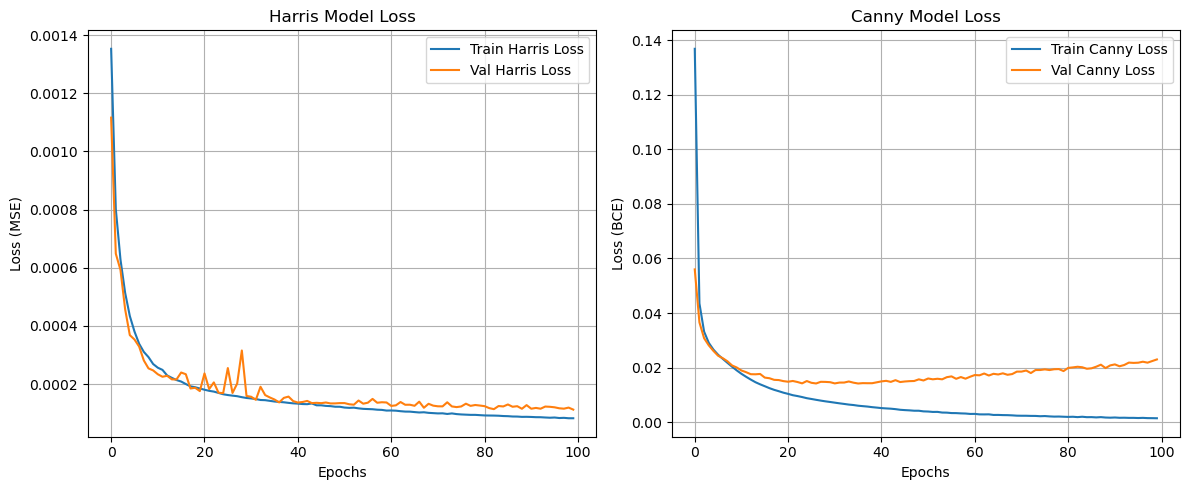

<Figure size 640x480 with 0 Axes>

In [139]:
# Run training
dataloaders = {'train': train_loader, 'val':val_loader}

# Start
trained_model_h, trained_model_c, history = train_model(
    model_harris, criterion_harris, optimizer_harris,
    model_canny, criterion_canny, optimizer_canny,
    dataloaders, device, num_epochs=NUM_EPOCHS
)

print("Training finished")

# save the model
torch.save(trained_model_h.state_dict(), 'unet_harris_best.pth')
torch.save(trained_model_c.state_dict(), 'unet_canny_best.pth')
print("Best model weights saved.")

# plot training hist
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss_h'], label='Train Harris Loss')
plt.plot(history['val_loss_h'], label='Val Harris Loss')
plt.title('Harris Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss_c'], label='Train Canny Loss')
plt.plot(history['val_loss_c'], label='Val Canny Loss')
plt.title('Canny Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (BCE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('training_history.png')

Both models demonstrate successful learning initially, followed by clear signs of overfitting, which is expected given the training data limitation.

Harris Model Loss (MSE):
Both training and validation losses decrease rapidly in the first ~20 epochs showing the model is quickly learning to map input patches to the Harris ground truth heatmap. After about 20-25 epochs the curves start to diverge.
The training loss continues to decrease steadily showing the model is getting better at fitting the specific patches it sees during training. The validation loss mostly plateaus and becomes quite noisy.
The model shows clear signs of overfitting as it is starting to memorize the training patches rather than learning a general representation of Harris corners. Its performance on the validation set (different locations/augmentations of the image) stops improving significantly. The noise suggests slight variations between validation batches affect performance.

Canny Model Loss (BCE):
Similarly both training and validation losses drop dramatically in the first ~15-20 epochs showing the model quickly learning the edge patterns.
The divergence here is even clearer and perhaps more detrimental. The training loss continues to decrease towards very low values (near zero) showing strong fitting to the training data.
The validation loss hits a minimum aroung epoch 20-30 and then starts to consistently increase for the rest of the training.
After epoch ~30, making the model better at the training patches actually makes it worse at predicting edges on the validation patches. It's excessively memorizing specific noise or patterns from the training patches that don't perfectly match the validation ones.

Overall:
The plots show that the models learned and the losses decreased. They show the expected overfitting due to the single training image. The validation loss correctly guided the selection of the best model weights.

In [142]:
trained_model_h.eval()
trained_model_c.eval()

# orig img dims
H, W = img_gray.shape

# calc padding needed to make dimensions % by patch size
pad_h = (PATCH_SIZE - H % PATCH_SIZE) % PATCH_SIZE
pad_w = (PATCH_SIZE - W % PATCH_SIZE) % PATCH_SIZE

img_gray_norm = img_gray.astype(np.float32) / 255.0 
input_padded = cv2.copyMakeBorder(img_gray_norm, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)

H_pad, W_pad = input_padded.shape

print(f"Original shape: ({H}, {W})")
print(f"Padding Added : H={pad_h}, W={pad_w}")
print(f"Padded Shape  : ({H_pad}, {W_pad})")

Original shape: (3744, 5616)
Padding Added : H=32, W=16
Padded Shape  : (3776, 5632)


In [144]:
# Create canvas for preds
harris_pred_canvas = np.zeros((H_pad, W_pad), dtype=np.float32)
canny_pred_canvas = np.zeros((H_pad, W_pad), dtype=np.float32)

# patch based predictions
print(f"predicting on full image using patches")
with torch.no_grad():
    for y in tqdm(range(0, H_pad, PATCH_SIZE), desc="Processing Rows"):
        for x in range(0, W_pad, PATCH_SIZE):
            # extract patch
            input_patch_np = input_padded[y : y + PATCH_SIZE, x : x + PATCH_SIZE]
            # preprocess patch
            input_patch_tensor = torch.from_numpy(input_patch_np)
            input_patch_tensor = input_patch_tensor.unsqueeze(0).unsqueeze(0) # adding batch and channel dims -> (1,1,P,P)
            input_patch_tensor = input_patch_tensor.to(device)
            # predict
            harris_pred_patch_tensor = trained_model_h(input_patch_tensor)
            canny_pred_patch_tensor = trained_model_c(input_patch_tensor)
            # post process patch
            harris_pred_patch_np = harris_pred_patch_tensor.squeeze().cpu().numpy() # (P, P)
            canny_pred_patch_np = canny_pred_patch_tensor.squeeze().cpu().numpy() # (P, P)

            # place into canvas 
            harris_pred_canvas[y : y + PATCH_SIZE, x : x + PATCH_SIZE] = harris_pred_patch_np
            canny_pred_canvas[y : y + PATCH_SIZE, x : x + PATCH_SIZE] = canny_pred_patch_np

# copying pred back to orig size
harris_pred_final = harris_pred_canvas[0:H, 0:W]
canny_pred_final = canny_pred_canvas[0:H, 0:W]

predicting on full image using patches


Processing Rows: 100%|██████████| 59/59 [00:07<00:00,  7.59it/s]


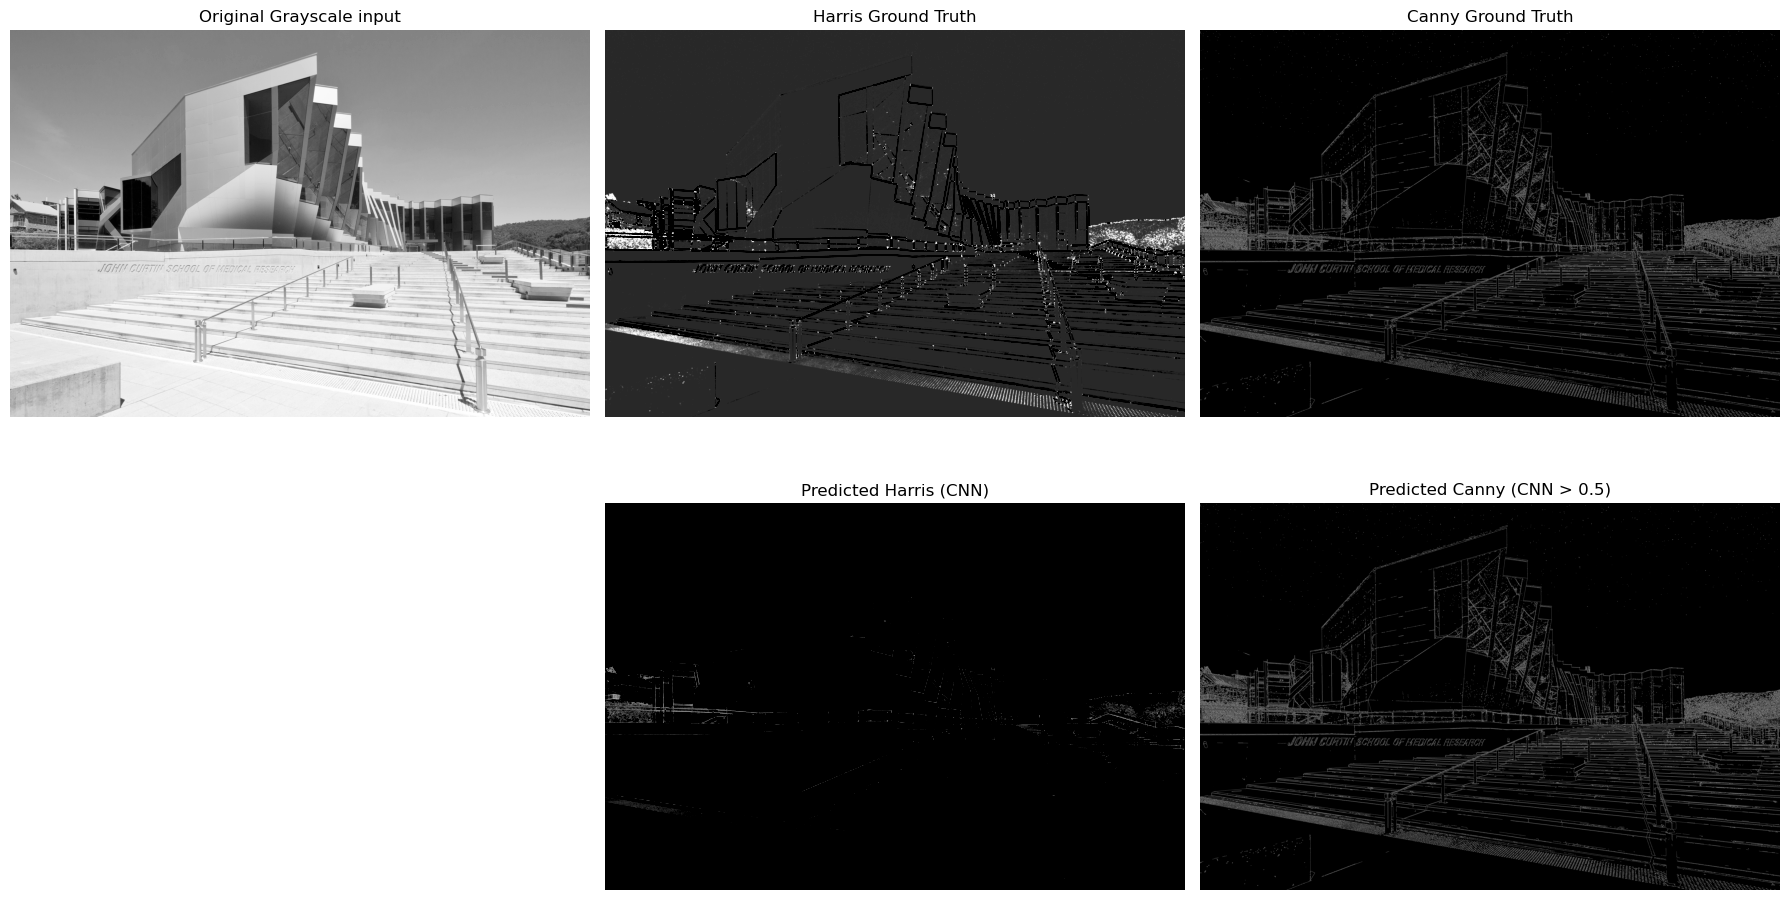

In [156]:
# Visualizing the predictions 
plt.figure(figsize=(18, 10))

# row 1: input and ground truths
plt.subplot(2, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Grayscale input')
plt.axis('off')

plt.subplot(2, 3, 2)
vmin_h, vmax_h = np.percentile(harris_normalized, [5, 99.5])
plt.imshow(harris_normalized, cmap='gray', vmin=vmin_h, vmax=vmax_h)
plt.title('Harris Ground Truth')
plt.axis('off')

plt.subplot(2, 3, 3)
canny = (canny_edges / 255.0).astype(np.float32)
plt.imshow(canny, cmap='gray')
plt.title('Canny Ground Truth')
plt.axis('off')

# row 2: predictions
plt.subplot(2, 3, 5)
plt.imshow(harris_pred_final, cmap='gray', vmin=vmin_h, vmax=vmax_h)
plt.title('Predicted Harris (CNN)')
plt.axis('off')

plt.subplot(2, 3, 6)
# plt.imshow(canny_pred_final, cmap='gray', vmin=0, vmax=1)
# plt.title('Predicted Canny (CNN Sigmoid)')
canny_pred_binary = (canny_pred_final > 0.5).astype(np.float32) # Threshold at 0.5
plt.imshow(canny_pred_binary, cmap='gray')
plt.title('Predicted Canny (CNN > 0.5)')
plt.axis('off')

plt.tight_layout()
plt.savefig('final_evaluation.png')
plt.show()

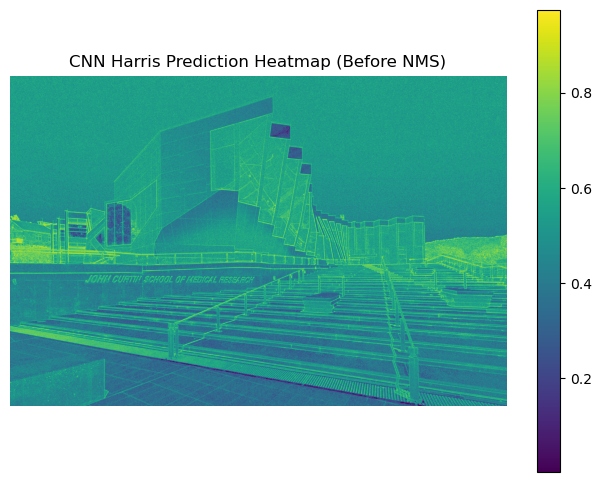

CNN Heatmap Stats: Min=0.0035, Max=0.9741, Mean=0.5085


In [165]:
plt.figure(figsize=(8, 6))
plt.imshow(harris_pred_final, cmap='viridis') # Use a colormap
plt.colorbar()
plt.title("CNN Harris Prediction Heatmap (Before NMS)")
plt.axis('off')
plt.savefig("cnn_harris_heatmap.png")
plt.show()

# Also check the range and distribution
print(f"CNN Heatmap Stats: Min={np.min(harris_pred_final):.4f}, Max={np.max(harris_pred_final):.4f}, Mean={np.mean(harris_pred_final):.4f}")

The heatmap clearly shows that the CNN has learned to associate the structural elements of the image (building edges, stairs, railings) with higher output values (brighter green/yellow). Flat areas like the sky (if visible) or smooth walls are darker
The heatmap confirms the CNN learned relevant features but might be better at detecting "edginess" or "structure" than specifically "cornerness."

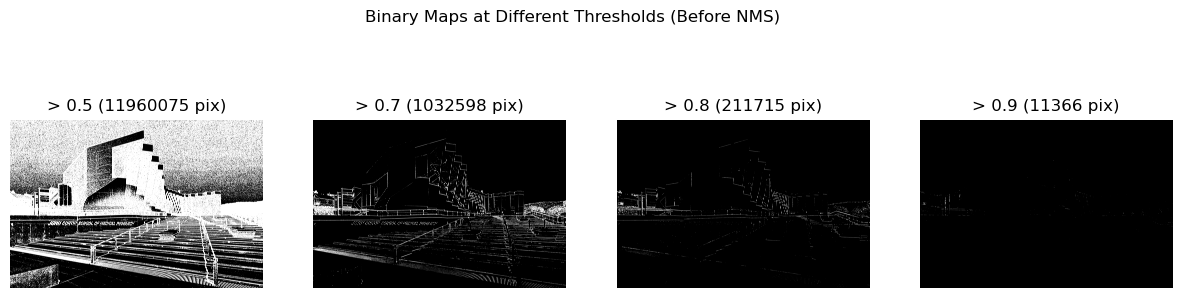

In [169]:
thresholds_to_test = [0.5, 0.7, 0.8, 0.9]
plt.figure(figsize=(15, 4))
for i, thresh in enumerate(thresholds_to_test):
    binary_map = (harris_pred_final > thresh).astype(np.uint8)
    num_pixels_above = np.sum(binary_map)
    plt.subplot(1, len(thresholds_to_test), i + 1)
    plt.imshow(binary_map, cmap='gray')
    plt.title(f'> {thresh:.1f} ({num_pixels_above} pix)')
    plt.axis('off')
plt.suptitle("Binary Maps at Different Thresholds (Before NMS)")
plt.savefig("cnn_heatmap_thresholds.png")
plt.show()

Detected 347626 corners from CNN prediction.


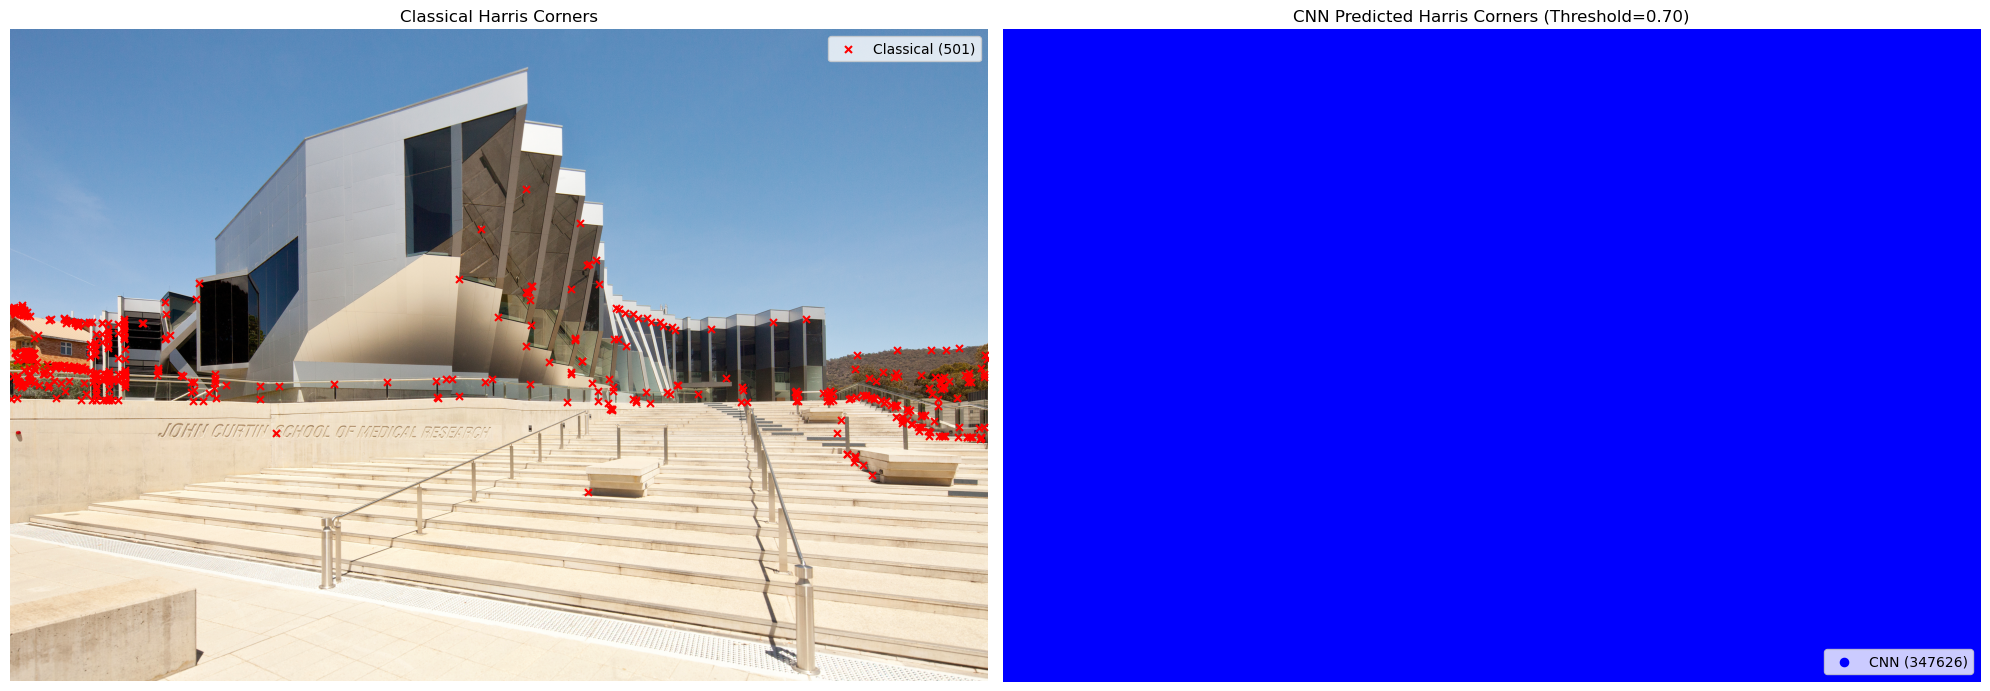

In [168]:
# params for CNN keypoint extraction
threshold_cnn = 0.7
window_size_nms = 5
# apply nms to cnn pred 
keypoints_cnn = harris_keypoint_nms(harris_pred_final, threshold_cnn_relative, window_size_nms)
print(f"Detected {len(keypoints_cnn)} corners from CNN prediction.")

if 'keypoints' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Plot Classical Keypoints
    axes[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    if keypoints:
        axes[0].scatter(*zip(*keypoints), c="red", s=25, marker="x", label=f"Classical ({len(keypoints)})") # Red X
    axes[0].set_title(f"Classical Harris Corners")
    axes[0].axis("off")
    axes[0].legend()

    # Plot CNN Keypoints
    axes[1].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    if keypoints_cnn:
        axes[1].scatter(*zip(*keypoints_cnn), c="blue", s=35, marker="o", label=f"CNN ({len(keypoints_cnn)})") # Blue circles
    axes[1].set_title(f"CNN Predicted Harris Corners (Threshold={threshold_cnn:.2f})")
    axes[1].axis("off")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig("harris_corners_comparison.png")
    plt.show()
else:
    print("Classical keypoints ('keypoints' variable) not found, skipping comparison plot.")

In [154]:
# Quantitative evaluation
# Harris MSE
mse_harris = np.mean((harris_normalized - harris_pred_final)**2)
print(f"Harris Prediction MSE: {mse_harris:.6f}")

# Canny Metrics (using the thresholded prediction)
canny = (canny_edges / 255.0).astype(np.float32)
canny_pred_binary = (canny_pred_final > 0.5).astype(np.uint8)
canny_gt_binary = canny.astype(np.uint8)
assert canny_pred_binary.shape == canny_gt_binary.shape, \
    f"Shape mismatch! Pred: {canny_pred_binary.shape}, GT: {canny_gt_binary.shape}"

accuracy_canny = np.mean(canny_pred_binary == canny_gt_binary)
print(f"Canny Pixel Accuracy: {accuracy_canny:.4f}")

# Intersection over Union (IoU) for edge pixels (class 1)
intersection = np.sum((canny_pred_binary == 1) & (canny_gt_binary == 1))
union = np.sum((canny_pred_binary == 1) | (canny_gt_binary == 1))
iou_canny = intersection / union if union > 0 else 0
print(f"Canny Edge IoU: {iou_canny:.4f}")

# Precision, Recall, F1-Score for edge pixels
true_positives = intersection
predicted_positives = np.sum(canny_pred_binary == 1)
actual_positives = np.sum(canny_gt_binary == 1)

precision = true_positives / predicted_positives if predicted_positives > 0 else 0
recall = true_positives / actual_positives if actual_positives > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Canny Edge Precision: {precision:.4f}")
print(f"Canny Edge Recall: {recall:.4f}")
print(f"Canny Edge F1-Score: {f1_score:.4f}")

Harris Prediction MSE: 0.079469
Canny Pixel Accuracy: 0.9982
Canny Edge IoU: 0.9577
Canny Edge Precision: 0.9795
Canny Edge Recall: 0.9772
Canny Edge F1-Score: 0.9784
